# Siamese One-Shot-Learning Network, [AT&T](https://www.cl.cam.ac.uk/research/dtg/attarchive/facedatabase.html) Faces Using [ReNom](https://www.renom.jp/)

In [ ]:
import os
import codecs
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import pairwise
from sklearn.preprocessing import normalize
from PIL import Image, ImageOps
import random
import datetime
import time

In [2]:
import renom as rm
from renom.optimizer import Adam
from renom.utility import *
from renom.cuda import set_cuda_active

## Set Configs

In [3]:
TRAIN_DIR = './datasets/faces/training/'
TEST_DIR = './datasets/faces/testing/'
BATCH_SIZE = 32
N_EPOCHS = 100
LR = 5e-4
N_GPU = 1

In [4]:
# check cuda availability
if rm.cuda.has_cuda() and N_GPU > 0: set_cuda_active(activate=True)
else: set_cuda_active(activate=False) 

## Set Helpers

In [5]:
def show_img(img, text=None, figsize=(20,20), should_save=False):
    
    plt.figure(figsize=figsize)
    plt.axis('off')
    if text:
        plt.text(75, 8, text, style='italic', fontweight='bold',
            bbox={'facecolor': 'white', 'alpha': 0.8, 'pad': 10 })
    plt.imshow(img, cmap='gray')
    plt.show()

## Configure Custom Data Generator

In [6]:
class SiameseDataGenerator(object):
    
    def __init__(self, datasets, transform=True, batch_size=64, should_invert=True):
        self.datasets = datasets
        self.transform = transform
        self.batch_size = batch_size
        self.should_invert = should_invert
    
    def __getitem__(self, train=True):
        
        imageA_data = []
        imageB_data = []
        label_data = []
        
        while True:
            imageA_tupple = random.choice(self.datasets)
            should_get_same_class = random.randint(0,1) # make sure approx 50% of images are in the same class
            if should_get_same_class:
                while True:
                    # keep looping until the same class image is found
                    imageB_tupple = random.choice(self.datasets)
                    if imageA_tupple[1] == imageB_tupple[1]:
                        break
            else:
                while True:
                    # keep looping until the different class image is found
                    imageB_tupple = random.choice(self.datasets)
                    if imageA_tupple[1] != imageB_tupple[1]:
                        break

            imageA = Image.open(imageA_tupple[0])
            imageB = Image.open(imageB_tupple[0])
            
            # the L means that it is just stores the Luminance
            imageA = imageA.convert('L')
            imageB = imageB.convert('L')

            if self.should_invert:
                imageA = ImageOps.invert(imageA)
                imageB = ImageOps.invert(imageB)

            if self.transform is not False:
                imageA = imageA.resize((100, 100))                
                imageB = imageB.resize((100, 100))
                
                imageA = normalize(imageA)
                imageB = normalize(imageB)
                
                imageA = np.expand_dims(imageA, axis=0)
                imageB = np.expand_dims(imageB, axis=0)

                imageA = np.array(imageA)
                imageB = np.array(imageB)
                
            imageA_data.append(imageA)
            imageB_data.append(imageB)
            label_data.append(np.array([int(imageA_tupple[1] != imageB_tupple[1])], dtype=np.float32))
            
            # compact data into batch
            if len(imageA_data) == self.batch_size:
                imageA_batch = np.array(imageA_data)
                imageB_batch = np.array(imageB_data)
                label_batch = np.array(label_data)
                imageA_data = []
                imageB_data = []
                label_data = []
                
                # return image A, image B and its similarity score (label)
                yield imageA_batch, imageB_batch, label_batch

In [7]:
def load_datasets(path_dir):
    datasets = list()
    train_list = [label for label in os.listdir(path_dir) if label != 'README']
    for idx_train, train in enumerate(train_list):
        image_list = os.listdir(path_dir + train)
        for image in image_list:
            datasets.append((path_dir + train + '/'  + image, idx_train))
            
    return datasets

In [8]:
datasets = load_datasets(path_dir=TRAIN_DIR)
siamese_generator = SiameseDataGenerator(datasets=datasets, transform=True, batch_size=BATCH_SIZE, should_invert=False)

## Visualize Data

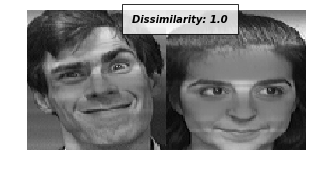

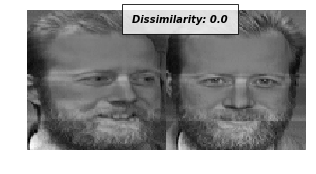

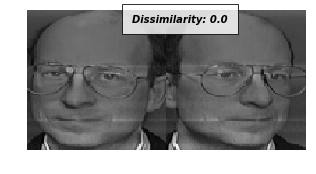

In [9]:
for _ in range(3):
    imageA, imageB, label = siamese_generator.__getitem__(True).__next__()
    
    stacked_image = np.hstack((imageA[0][0], imageB[0][0]))
    show_img(stacked_image, text="Dissimilarity: {}".format(label[0][0]), figsize=(5,5))

## Build [Siamese Network](https://www.cs.cmu.edu/~rsalakhu/papers/oneshot1.pdf) Architecture

In [221]:
class SiameseNet(rm.Model):
    
    def __init__(self):
        super(SiameseNet, self).__init__()
        self.conv_layer = rm.Sequential([
            rm.Conv2d(channel=4, filter=3, padding=1),
            rm.Relu(),
            
            rm.Conv2d(channel=8, filter=3, padding=1),
            rm.Relu(),
            
            rm.Conv2d(channel=8, filter=3, padding=1),
            rm.Relu(),
        ])
        
        self.fc_layer = rm.Sequential([
            rm.Dense(500),
            rm.Relu(),
            rm.Dense(500),
            rm.Relu(),
            rm.Dense(5)
        ])
        
    def forward_once(self, x):
        print('before')
        print(x.min())
        print(x.max())
        x = self.conv_layer(x)
        print('after')
        print(x.min())
        print(x.max())
        x = x.reshape(x.shape[0], -1)
        x = self.fc_layer(x)
        
        return x
    
    def forward(self, imageA, imageB):
        resultA = self.forward_once(imageA)
        resultB = self.forward_once(imageB)
        
        return resultA, resultB
    
def contrastive_loss(resultA, resultB, label, margin=2.0):
    
    euclidean_distance = pairwise.euclidean_distances(resultA, resultB)
    contrastive_loss = rm.mean((1-label) * np.power(euclidean_distance, 2) +
                               (label) * np.power(np.clip(margin - euclidean_distance, a_min=0.0, a_max=(margin - euclidean_distance).max()), 2))

    
    return contrastive_loss

#### Initialize Siamese Network

In [251]:
imageA, imageB, label = siamese_generator.__getitem__(True).__next__()

--- Before CONV
0.0
0.25611987709999084
torch.Size([32, 1, 100, 100])


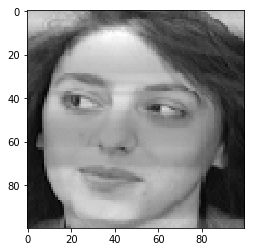

--- After CONV
0.0
0.1628451943397522
torch.Size([32, 8, 100, 100])


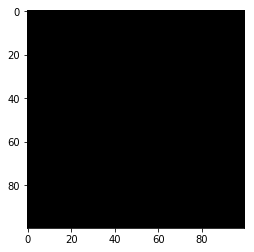

--- Before CONV
0.0
0.33062487840652466
torch.Size([32, 1, 100, 100])


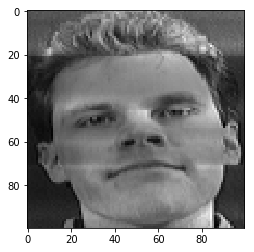

--- After CONV
0.0
0.1627746820449829
torch.Size([32, 8, 100, 100])


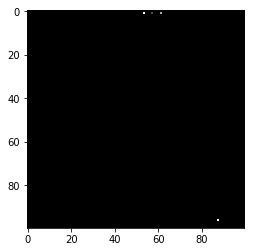

0.0 0.0006852878


In [252]:
nn_pytorch(imageA, imageB, label)

--- Before CONV
0.0
0.25611988207269826
(32, 1, 100, 100)


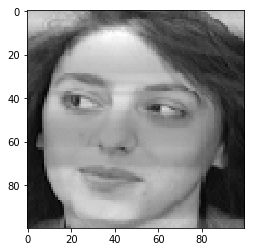

--- After CONV
0.0
0.109066315
(32, 8, 100, 100)


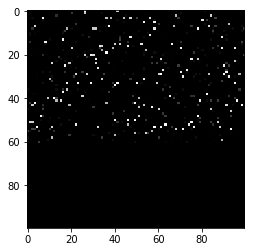

--- Before CONV
0.0
0.33062487524984324
(32, 1, 100, 100)


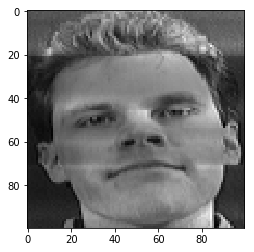

--- After CONV
0.0
0.14192988
(32, 8, 100, 100)


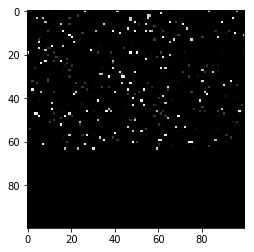

0.0 inf


/usr/local/lib/python3.6/dist-packages/numpy/core/_methods.py:36: RuntimeWarning: overflow encountered in reduce
  return umr_sum(a, axis, dtype, out, keepdims, initial)


In [253]:
nn_renom(imageA, imageB, label)

## Loss Function

In [14]:
def contrastive_loss(resultA, resultB, label, margin=2.0):
    euclidean_distance = pairwise.euclidean_distances(resultA, resultB)
    contrastive_loss = rm.mean((1-label) * np.power(euclidean_distance, 2) +
                               (label) * np.power(np.clip(margin - euclidean_distance, a_min=0.0, a_max=(margin - euclidean_distance).max()), 2))
    
    return contrastive_loss

## Set Optimizer

In [15]:
optimizer = rm.Adam(lr=LR)

## Train The Network

---

# PYTORCH

In [243]:
def nn_renom(imageA, imageB, label):
    class SiameseNet(rm.Model):

        def __init__(self):
            super(SiameseNet, self).__init__()
            self.conv_layer = rm.Sequential([
                rm.Conv2d(channel=4, filter=3, padding=1),
                rm.Relu(),

                rm.Conv2d(channel=8, filter=3, padding=1),
                rm.Relu(),

                rm.Conv2d(channel=8, filter=3, padding=1),
                rm.Relu(),
            ])

            self.fc_layer = rm.Sequential([
                rm.Dense(500),
                rm.Relu(),
                rm.Dense(500),
                rm.Relu(),
                rm.Dense(5)
            ])

        def forward_once(self, x):
            print('--- Before CONV')
            print(x.min())
            print(x.max())
            print(x.shape)
            
            plt.imshow(x[0][0], cmap='gray')
            plt.show()
            x = self.conv_layer(x)
            print('--- After CONV')
            print(x.min())
            print(x.max())
            print(x.shape)
            
            plt.imshow(x[0][0], cmap='gray')
            plt.show()
            x = x.reshape(x.shape[0], -1)
            x = self.fc_layer(x)

            return x

        def forward(self, imageA, imageB):
            resultA = self.forward_once(imageA)
            resultB = self.forward_once(imageB)

            return resultA, resultB

    siamese = SiameseNet()
    
    def contrastive_loss(resultA, resultB, label, margin=2.0):

        euclidean_distance = pairwise.euclidean_distances(resultA, resultB)
        contrastive_loss = rm.mean((1-label) * np.power(euclidean_distance, 2) +
                                   (label) * np.power(np.clip(margin - euclidean_distance, a_min=0.0, a_max=(margin - euclidean_distance).max()), 2))


        return contrastive_loss

    resultA, resultB = siamese(imageA, imageB)
    euclidean_distance = pairwise.euclidean_distances(resultA, resultB)
    print(euclidean_distance.min(), euclidean_distance.max())

In [244]:
def nn_pytorch(imageA, imageB, label):
    import torch
    import torchvision
    import torchvision.transforms as transforms
    import torchvision.datasets as datasets
    import torch.nn as nn
    import torch.optim as optim
    import torch.nn.functional as F

    from torch.autograd import Variable
    from torch.utils.data import DataLoader
    from torchvision.utils import save_image

    # decide which device we want to run on
    device = torch.device('cuda:0' if (torch.cuda.is_available() and N_GPU > 0) else 'cpu')

    class SiameseNet(nn.Module):

        def __init__(self):
            super(SiameseNet, self).__init__()
            self.conv_layer = nn.Sequential(
                nn.ZeroPad2d(1),
                nn.Conv2d(1, 4, kernel_size=3),
                nn.ReLU(),

                nn.ZeroPad2d(1),
                nn.Conv2d(4, 8, kernel_size=3),
                nn.ReLU(),

                nn.ZeroPad2d(1),
                nn.Conv2d(8, 8, kernel_size=3),
                nn.ReLU(),
            )

            self.fc_layer = nn.Sequential(
                nn.Linear(8*100*100, 500),
                nn.ReLU(inplace=True),
                nn.Linear(500, 500),
                nn.ReLU(inplace=True),
                nn.Linear(500, 5))

        def forward_once(self, x):
            print('--- Before CONV')
            print(x.min().item())
            print(x.max().item())
            print(x.shape)
            
            plt.imshow(x[0][0].detach().cpu(), cmap='gray')
            plt.show()
            x = self.conv_layer(x)
            print('--- After CONV')
            print(x.min().item())
            print(x.max().item())
            print(x.shape)
            
            plt.imshow(x[0][0].detach().cpu(), cmap='gray')
            plt.show()
            x = x.view(x.size()[0], -1)
            x = self.fc_layer(x)

            return x

        def forward(self, imageA, imageB):
            resultA = self.forward_once(imageA)
            resultB = self.forward_once(imageB)

            return resultA, resultB

    siamese = SiameseNet().to(device)

    def contrastive_loss(resultA, resultB, label, margin=2.0):
        euclidean_distance = pairwise.euclidean_distances(resultA, resultB)
        euclidean_distance = torch.from_numpy(euclidean_distance)
        print('euclidean_distance: {} - {}'.format(euclidean_distance.min(), euclidean_distance.max()))
        to_mean = (1-label) * np.power(euclidean_distance, 2) + (label) * np.power(np.clip(margin - euclidean_distance, a_min=0.0, a_max=(margin - euclidean_distance).max()), 2)
        contrastive_loss = np.mean(to_mean.numpy())

        return contrastive_loss
    
    imageA, imageB, label = torch.from_numpy(imageA), torch.from_numpy(imageB), torch.from_numpy(label)
    imageA, imageB, label = imageA.to(device), imageB.to(device), label.to(device)
    imageA, imageB, label = imageA.float(), imageB.float(), label.float()

    resultA, resultB = siamese(imageA, imageB)
    euclidean_distance = pairwise.euclidean_distances(resultA.detach().cpu(), resultB.detach().cpu())
    print(euclidean_distance.min(), euclidean_distance.max())

---